<a href="https://colab.research.google.com/github/yashnarkhede/Mental-Health-Prediction/blob/main/twitter_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import nltk
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [11]:
df = pd.read_csv("/content/train.csv")
df.head()

,tweets,labels
0,sending solidarity whoever doctor manage incre...,Stressed
1,need see hair amp beard gat book appointment b...,Anxious
2,next time meet someone new dont ask ask love,Normal
3,surprise someone love give la senza gift box r...,Lonely
4,raise hand junhoes ocean lotion life rent free...,Normal


In [12]:
def preprocess_text(df,column_name):
    
    df[column_name] = df[column_name].apply(lambda x: " ".join(x.lower() for x in x.split()))
    df[column_name] = df[column_name].str.replace('[^\w\s]','')
    #remove stop words
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    df[column_name] = df[column_name].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    #spell correct 
    #df[column_name].apply(lambda x: str(TextBlob(x).correct()))
    st = PorterStemmer()
    df[column_name][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
    #lemmatize
    df[column_name] = df[column_name].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return df
    

In [25]:
preproeessed_df_train = preprocess_text(df,"tweets")
preproeessed_df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,tweets,labels
0,sending solidarity whoever doctor manage incre...,Stressed
1,need see hair amp beard gat book appointment b...,Anxious
2,next time meet someone new dont ask ask love,Normal
3,surprise someone love give la senza gift box r...,Lonely
4,raise hand junhoes ocean lotion life rent free...,Normal
...,...,...
29987,originsmp originssmp,Normal
29988,name muhammad asif farooqi im pakistan amp sta...,Lonely
29989,mom mad wont go overnight skiing trip 5 people...,Stressed
29990,even tonight youre go bed date someone cannot ...,Normal


In [14]:
frequency_dist = nltk.FreqDist(df['tweets'])
ordereddist =sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

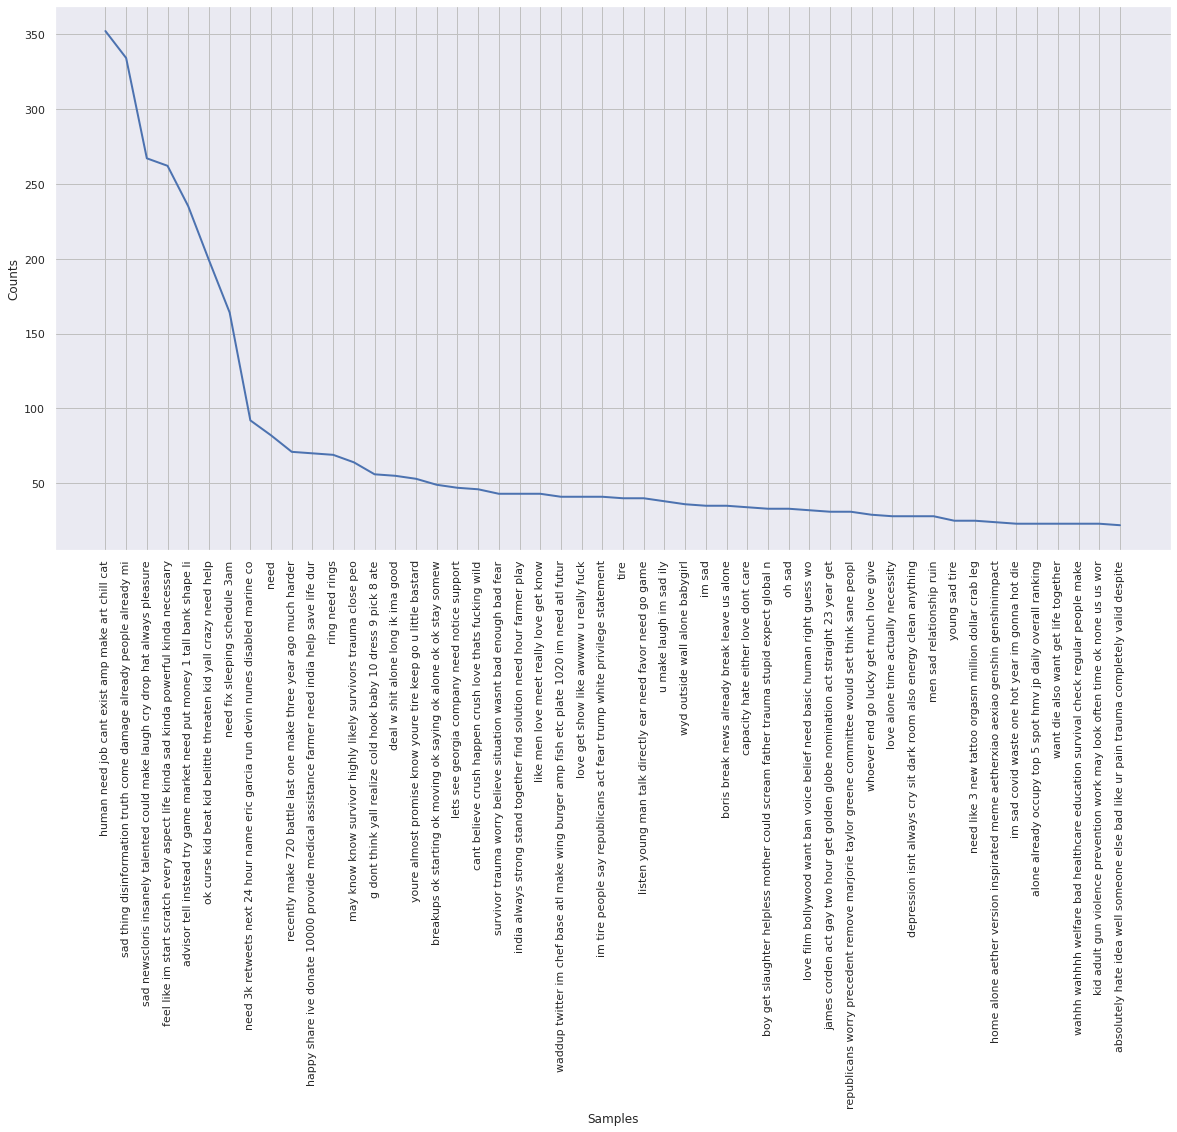

In [15]:
sns.set(rc={'figure.figsize':(20,10)})
large_words = dict([(k,v) for k,v in frequency_dist.items() if len(k)>3])
frequency_dist = nltk.FreqDist(large_words)
frequency_dist.plot(50,cumulative=False)  

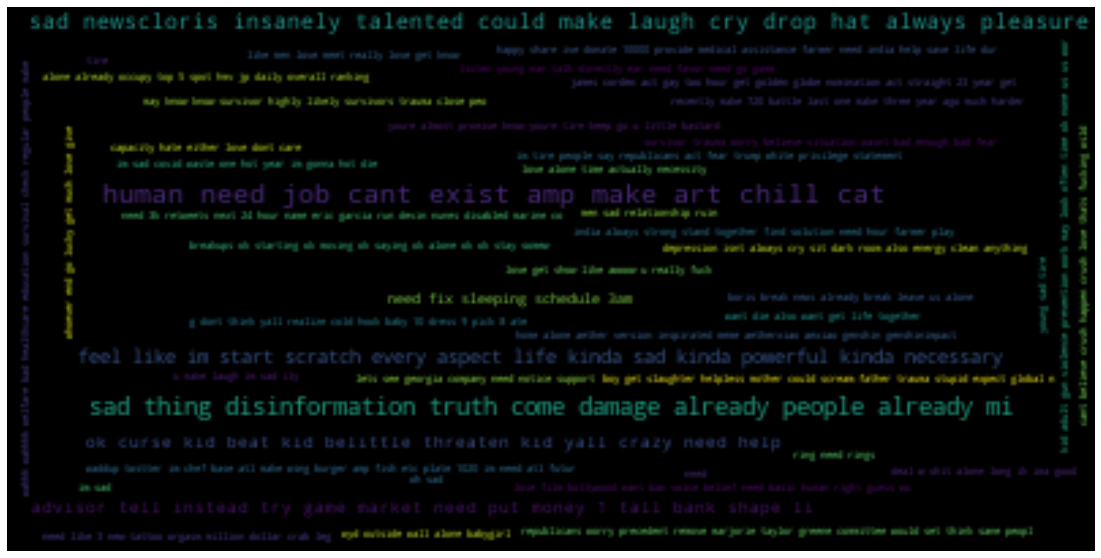

In [16]:
sns.set(rc={'figure.figsize':(20,10)})
from wordcloud import WordCloud
wcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off") 
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(preproeessed_df_train["tweets"],
                                                      preproeessed_df_train["labels"],
                                                     random_state=4546,
                                                     test_size=0.3)

In [28]:
X_train.shape, X_valid.shape

((20994,), (8998,))

In [29]:
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf.fit(X_train)
encoded_X_train =  tfidf.transform(X_train)
encoded_X_valid =  tfidf.transform(X_valid)
encoded_X_train.data

array([0.22583806, 0.45037087, 0.20046882, ..., 0.65042601, 0.27653053,
       0.70744389])

In [30]:
# rfparams = {'n_estimators':[100,200,300,500],
#             'max_features':['auto','log2','sqrt'],
#             'criterion':['gini','entropy'],
#             'min_samples_split': [3,5,8,9,10,30,50]}
# rf_gridcv = GridSearchCV(RandomForestClassifier(random_state=42), rfparams, verbose=1, n_jobs=12, cv=10)
# rf_gridcv.fit(encoded_X_train,y_train)
# rf_pred = rf_gridcv.predict(encoded_X_valid)
# metrics.accuracy_score(rf_pred, y_valid)

In [31]:
#naive bayes
nb = naive_bayes.MultinomialNB(alpha=0.2)
nb.fit(encoded_X_train,y_train)
predict = nb.predict(encoded_X_valid)
metrics.accuracy_score(predict, y_valid)

0.5435652367192709

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [33]:
gb = GradientBoostingClassifier(random_state=412)
gb.fit(encoded_X_train,y_train)
gbpredict = gb.predict(encoded_X_valid)
metrics.accuracy_score(gbpredict, y_valid)

0.6738164036452545

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


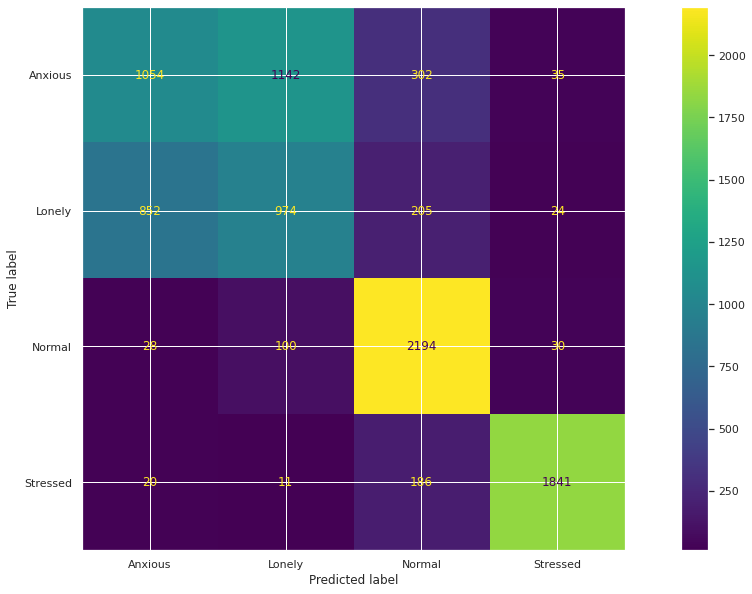

In [34]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gb, encoded_X_valid, y_valid)  

In [36]:
test_df = pd.read_csv("/content/test.csv")
preprocess_test=preprocess_text(test_df,"tweets")
preprocess_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,id,tweets
0,0,wish luck need start cooking
1,1,ino didnt need weapon need backup cause damn s...
2,2,good thing know walk away
3,3,say fat people get tire fast
4,4,need buy fucken car already
...,...,...
7494,7494,love mercedes justine kestner varnadohelp thanks
7495,7495,junkie xl score everyone damn beautifuk
7496,7496,92e3201a battle id need backup lvl 200 ultimat...
7497,7497,tangina naiiyak ako sa mga nangyayari please n...


In [37]:
gbres =  gb.predict(tfidf.transform(preprocess_test["tweets"]))
gbres_df= pd.concat([preprocess_test["id"],pd.DataFrame(gbres,columns=['labels'])],axis=1)
gbres_df

,id,labels
0,0,Lonely
1,1,Anxious
2,2,Normal
3,3,Stressed
4,4,Lonely
...,...,...
7494,7494,Lonely
7495,7495,Normal
7496,7496,Lonely
7497,7497,Lonely


In [ ]:
# gbres_df.to_csv("submission.csv")

In [38]:
from sklearn.linear_model import SGDClassifier
clf=SGDClassifier(max_iter=100, tol=1e-3)
clf.fit(encoded_X_train,y_train)
sgdp = clf.predict(encoded_X_valid)
metrics.accuracy_score(sgdp, y_valid)

0.6565903534118693

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


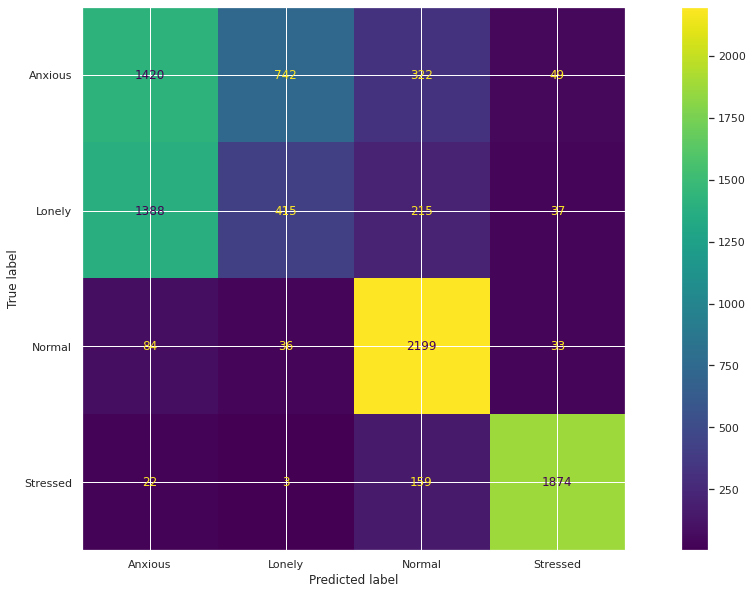

In [39]:
plot_confusion_matrix(clf, encoded_X_valid, y_valid)  

In [40]:
#SGD Prediction
sgdres =  clf.predict(tfidf.transform(preprocess_test["tweets"]))
sgdres_df= pd.concat([preprocess_test["id"],pd.DataFrame(sgdres,columns=['labels'])],axis=1)
sgdres_df

,id,labels
0,0,Anxious
1,1,Anxious
2,2,Normal
3,3,Stressed
4,4,Lonely
...,...,...
7494,7494,Anxious
7495,7495,Normal
7496,7496,Lonely
7497,7497,Lonely
